In [6]:
import pandas as pd


# Load the file
input_file = "original_id_assignments.txt"  # Update with your actual file name
output_file = "filtered_support_8.csv"

# Read the file as a tab-separated file, ensuring NA values are not converted to NaN
df = pd.read_csv(input_file, sep="\t", dtype=str, keep_default_na=False)

# Filter rows containing 'support_8' in the 'original_ID' column
filtered_df = df[df["original_ID"].str.contains("support_8", na=False)]

# Save to a CSV file, ensuring "NA" values remain as-is
filtered_df.to_csv(output_file, index=False, na_rep="NA", sep="\t")

print(f"Filtered data saved to {output_file}")

Filtered data saved to filtered_support_8.csv


In [7]:
import os
import glob
from collections import defaultdict

# Define input and output paths
input_files = glob.glob("LP6008051-DNA_*_filtered_out_ids.txt")
output_dir = "filtered_results"
os.makedirs(output_dir, exist_ok=True)

for file in input_files:
    merged_entries = defaultdict(set)  # Dictionary to store merged entries

    with open(file, "r") as f:
        for line in f:
            line = line.strip()
            if "support_8" in line:
                # Extract unique ID and reason
                parts = line.rsplit("__", 1)
                unique_id = parts[0]
                reason = parts[1] if len(parts) > 1 else "unknown"
                
                # Store reasons under the same unique ID
                merged_entries[unique_id].add(reason)

    # Write filtered and merged results to a new file
    output_file = os.path.join(output_dir, os.path.basename(file).replace(".txt", "_filtered.txt"))
    with open(output_file, "w") as out:
        for unique_id, reasons in merged_entries.items():
            merged_line = f"{unique_id}__{' + '.join(sorted(reasons))}"
            out.write(merged_line + "\n")

    print(f"Processed {file} -> {output_file}")

Processed LP6008051-DNA_A03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_A03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_B03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_B03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_C03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_C03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_D03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_D03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_E03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_E03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_F03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_F03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_G03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_G03__filtered_out_ids_filtered.txt
Processed LP6008051-DNA_H03__filtered_out_ids.txt -> filtered_results\LP6008051-DNA_H03__filtered_out_ids_filtered.txt


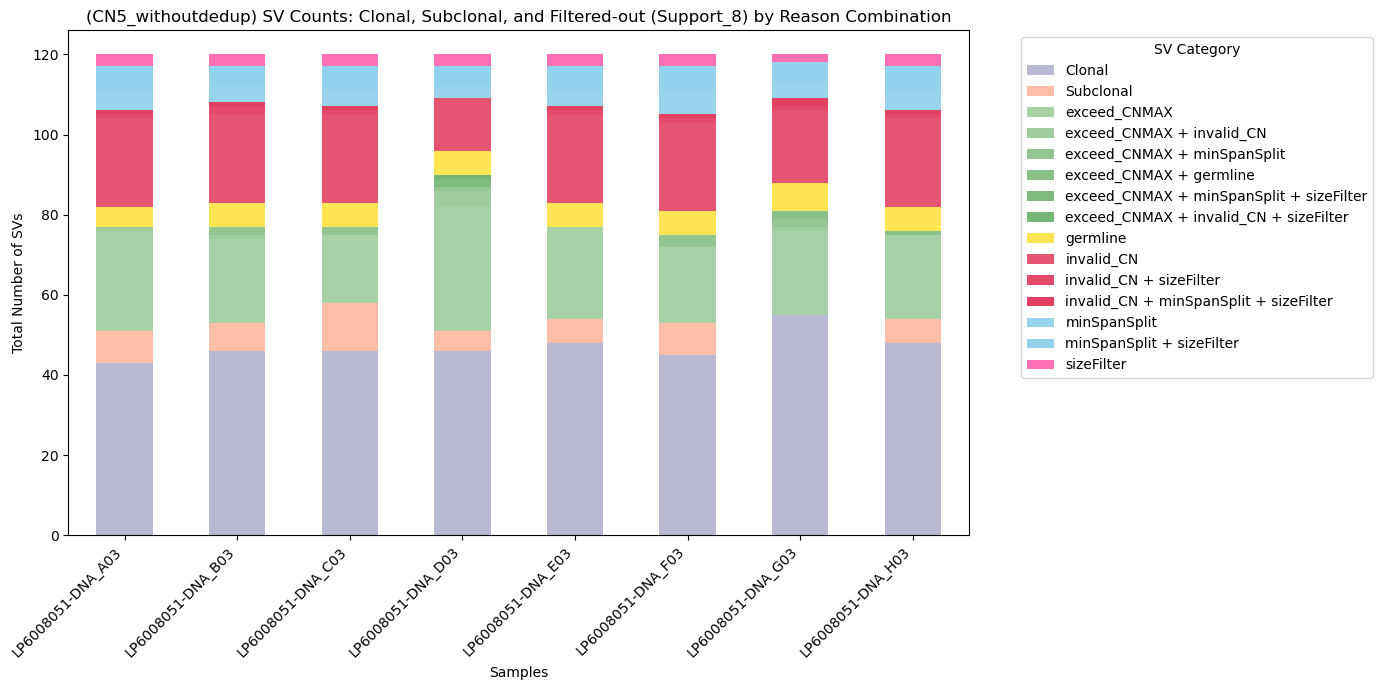

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import matplotlib.colors as mcolors
import os


# --- Step 1: Load the SV Clustering Data ---
df = pd.read_csv("filtered_support_8.csv", sep="\t")  # Ensure correct delimiter
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric)  # Convert clustering values to numbers

# --- Step 2: Extract Unique Support_8 SVs with Pre-Defined Filtering Reasons ---
filter_files = glob.glob("filtered_results/*__filtered_out_ids_filtered.txt")  

# Dictionary to store SV counts per filtering reason per sample
support_8_counts = {sample: defaultdict(int) for sample in df.columns[1:]}

for file in filter_files:
    file = file.replace("\\", "/")  # Ensure consistent file path formatting
    sample_name = file.split("filtered_results/")[1].split("__filtered_out_ids_filtered.txt")[0]  # Extract sample name

    if sample_name not in support_8_counts:
        support_8_counts[sample_name] = defaultdict(int)

    with open(file, "r") as f:
        filtered_svs = f.readlines()

    for sv in filtered_svs:
        sv_info = sv.strip().split("__")  # Extract SV ID and filtering reason
        if len(sv_info) < 2:
            continue  # Skip invalid lines

        sv_filter_reason = sv_info[-1]  # The filtering reason
        support_8_counts[sample_name][sv_filter_reason] += 1  # Count occurrences

# --- Step 3: Count Clonal (2) and Subclonal (1) SVs Per Sample ---
cluster_counts = {}

for sample in df.columns[1:]:  # Skip 'original_ID'
    count_clonal = (df[sample] == 2.0).sum()
    count_subclonal = (df[sample] == 1.0).sum()

    if count_clonal == 0:
        count_clonal = count_subclonal  # Convert all '1' to '2'
        count_subclonal = 0  # Reset subclonal count

    # Merge cluster counts and filtering reason combinations
    cluster_counts[sample] = {
        "Clonal": count_clonal,
        "Subclonal": count_subclonal,
        **support_8_counts.get(sample, {})  # Include filtering reasons
    }

# Convert to DataFrame
support_8_df = pd.DataFrame.from_dict(cluster_counts, orient="index").reset_index()
support_8_df.rename(columns={"index": "Sample"}, inplace=True)

# --- Step 4: Define a Fixed Color Mapping for Consistency ---

# Predefine all possible filtering reasons manually or dynamically collect them from multiple runs
# Define base colors for each main category
color_families = {
    "exceed_CNMAX": "forestgreen",
    "invalid_CN": "crimson",
    "minSpanSplit": "skyblue",
    "sizeFilter": "hotpink",  # Ensure it stays visible
    "germline": "gold",
    "Subclonal": "orangered",  # More intense coral/red
    "Clonal": "midnightblue"  # Deep & sharp blue
}

# Function to count number of reasons in a category
def reason_complexity(reason):
    return reason.count(" + ")  # Higher count → More complex combination

# Sort reasons by category and complexity
sorted_reasons = sorted(support_8_df.columns[1:], key=lambda x: (x.split(" ")[0], reason_complexity(x)))

# Function to generate sharper color shades
def assign_shaded_color(reason, index, total_variants):
    base_color = None
    for prefix, color in color_families.items():
        if reason.startswith(prefix):
            base_color = color
            break

    if base_color:
        # Increase contrast: Range from 40% dark → 90% light (avoiding too-white colors)
        shade_factor = 0.3 + (0.7 * (index / total_variants))  
        shaded_color = mcolors.to_rgba(mcolors.to_hex(mcolors.CSS4_COLORS[base_color]), alpha=shade_factor)
        return shaded_color
    
    return "gray"  # Default for unknown reasons

# Generate colors with improved contrast
total_variants = len(sorted_reasons)
fixed_colors = {reason: assign_shaded_color(reason, idx, total_variants) for idx, reason in enumerate(sorted_reasons)}

folder_name = os.path.basename(os.getcwd())

# Generate title dynamically
chart_title = f"({folder_name}) SV Counts: Clonal, Subclonal, and Filtered-out (Support_8) by Reason Combination"

# Plot with dynamic title
support_8_df.set_index("Sample")[sorted_reasons].plot(
    kind="bar", stacked=True,
    color=[fixed_colors[col] for col in sorted_reasons],  
    figsize=(14, 7),
    width=0.5
)

#ax = plt.gca()
#for bar in ax.patches:
#    height = bar.get_height()
#    if height > 0:
#       ax.annotate(f"{int(height)}", 
#                   (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
#                    ha='center', va='center', fontsize=8, color='black')



plt.xlabel("Samples")
plt.ylabel("Total Number of SVs")
plt.title(chart_title, fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="SV Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

def simplify_sample_name(sample_name):
    match = re.search(r"-DNA_([A-H])\d{2}$", sample_name)
    return match.group(1) if match else sample_name  # Default to original if no match

# Apply the function to rename the index
simplified_labels = [simplify_sample_name(sample) for sample in support_8_df["Sample"]]



ax = support_8_df.set_index("Sample")[sorted_reasons].plot(
    kind="bar", stacked=True,
    color=[fixed_colors[col] for col in sorted_reasons],  
    figsize=(4, 4),
    width=0.5
)

ax.set_xticks(range(len(simplified_labels)))  # Set positions of ticks
ax.set_xticklabels(simplified_labels, rotation=0)  # Apply the simplified labels
ax.set_xlabel("")

# --- Hide the legend ---
ax.legend_.remove()

output_filename = f"{folder_name}.png"
plt.tight_layout()
plt.savefig(output_filename, dpi=300)
plt.close()  # Don't show now, just save

def simplify_sample_name(sample_name):
    match = re.search(r"-DNA_([A-H])\d{2}$", sample_name)
    return match.group(1) if match else sample_name  # Default to original if no match

# Apply the function to rename the index
simplified_labels = [simplify_sample_name(sample) for sample in support_8_df["Sample"]]



ax = support_8_df.set_index("Sample")[sorted_reasons].plot(
    kind="bar", stacked=True,
    color=[fixed_colors[col] for col in sorted_reasons],  
    figsize=(4, 4),
    width=0.5
)

ax.set_xticks(range(len(simplified_labels)))  # Set positions of ticks
ax.set_xticklabels(simplified_labels, rotation=0)  # Apply the simplified labels
ax.set_xlabel("")

# --- Hide the legend ---
ax.legend_.remove()

output_filename = f"{folder_name}.png"
plt.tight_layout()
plt.savefig(output_filename, dpi=300)
plt.close()  # Don't show now, just save





In [4]:
import os
import pandas as pd
import scipy.stats as stats

# Load datasets
df_common = pd.read_csv("filtered_support_8.csv", sep="\t")  # Common SVs
df_all = pd.read_csv("original_id_assignments.txt", sep="\t")  # All SVs

# Convert SV cluster values to numeric
df_common.iloc[:, 1:] = df_common.iloc[:, 1:].apply(pd.to_numeric)
df_all.iloc[:, 1:] = df_all.iloc[:, 1:].apply(pd.to_numeric)

# Store test results
test_results = {}

# Iterate over each sample
for sample in df_common.columns[1:]:
    # Common SVs counts
    count_cluster_2_common = (df_common[sample] == 2).sum()
    count_cluster_1_common = (df_common[sample] == 1).sum()

    # All SVs counts
    total_cluster_2_all = (df_all[sample] == 2).sum()
    total_cluster_1_all = (df_all[sample] == 1).sum()

    # Rest counts (excluding common SVs)
    rest_cluster_2 = total_cluster_2_all - count_cluster_2_common
    rest_cluster_1 = total_cluster_1_all - count_cluster_1_common

    # Skip if no data
    if (count_cluster_1_common + count_cluster_2_common) == 0:
        continue

    # Construct contingency table
    contingency_table = [[count_cluster_2_common, count_cluster_1_common],
                         [rest_cluster_2, rest_cluster_1]]

    # Fisher's Exact Test (two-tailed)
    oddsratio, p_two_tailed = stats.fisher_exact(contingency_table, alternative='two-sided')

    # Fisher's Exact Test (one-tailed, greater)
    _, p_one_tailed = stats.fisher_exact(contingency_table, alternative='greater')

    # Store results
    test_results[sample] = {
        "Odds Ratio": oddsratio,
        "Fisher Two-tailed p-value": p_two_tailed,
        "Fisher One-tailed (greater) p-value": p_one_tailed
    }

# Convert to DataFrame
test_results_df = pd.DataFrame.from_dict(test_results, orient="index").reset_index()
test_results_df.columns = ["Sample", "Odds Ratio", "Fisher Two-tailed p-value", "Fisher One-tailed (greater) p-value"]

# Get the current folder name
folder_name = os.path.basename(os.getcwd())

# Save with dynamic filename and folder header
output_filename = f"{folder_name}_fisher_test_results.csv"
with open(output_filename, "w", newline="") as f:
    f.write(f"{folder_name}\n")  # Add folder name as first line
    test_results_df.to_csv(f, index=False, lineterminator="\n")

# Display summary
print(f"\nResults saved as: {output_filename}")
print("\nFisher’s test results:")
print(test_results_df)



Results saved as: CN5_withoutdedup_fisher_test_results.csv

Fisher’s test results:
              Sample  Odds Ratio  Fisher Two-tailed p-value  \
0  LP6008051-DNA_A03    4.473602               4.548824e-05   
1  LP6008051-DNA_B03    2.478367               3.461318e-02   
2  LP6008051-DNA_C03    5.998457               1.635113e-08   
3  LP6008051-DNA_D03    5.914286               1.906045e-04   
4  LP6008051-DNA_E03    3.382857               3.781161e-03   
5  LP6008051-DNA_F03    1.209375               8.409342e-01   
6  LP6008051-DNA_G03         NaN               1.000000e+00   
7  LP6008051-DNA_H03    2.957346               1.486351e-02   

   Fisher One-tailed (greater) p-value  
0                         2.954415e-05  
1                         1.958772e-02  
2                         1.406701e-08  
3                         1.089771e-04  
4                         2.598685e-03  
5                         4.105658e-01  
6                         1.000000e+00  
7                   